# DATA20001 Deep Learning - Group Project
## Text project

**Due Thursday, May 20, before 23:59.**

The task is to learn to assign the correct labels to news articles.  The corpus contains ~850K articles from Reuters.  The test set is about 10% of the articles. The data is unextracted in XML files.

We're only giving you the code for downloading the data, and how to save the final model. The rest you'll have to do yourselves.

Some comments and hints particular to the project:

- One document may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are documents that don't belong to any class, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.
- You may use word-embeddings to get better results. For example, you were already using a smaller version of the GloVE  embeddings in exercise 4. Do note that these embeddings take a lot of memory. 
- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

## Get the data

In [1]:
import sys
import os
from os.path import join
from os.path import abspath
from os.path import split

import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

root_dir = os.getcwd()
if root_dir not in sys.path:
    sys.path.append(root_dir)
    
train_path = 'train'

data_folder_name = 'text-training-corpus'
DATA_FOLDER_DIR = os.path.abspath(os.path.join(root_dir, data_folder_name))

data_zip_name = 'reuters-training-corpus.zip'
DATA_ZIP_DIR = os.path.abspath(os.path.join(DATA_FOLDER_DIR, data_zip_name))

#with zipfile.ZipFile(DATA_ZIP_DIR) as zip_f:
#    zip_f.extractall(train_path)

In [2]:
#pip install pytorch-nlp
#pip install lxml

The above command downloads and extracts the data files into the `train` subdirectory.

The files can be found in `train/`, and are named as `19970405.zip`, etc. You will have to manage the content of these zips to get the data. There is a readme which has links to further descriptions on the data.

The class labels, or topics, can be found in the readme file called `train/codes.zip`.  The zip contains a file called "topic_codes.txt".  This file contains the special codes for the topics (about 130 of them), and the explanation - what each code means.  

The XML document files contain the article's headline, the main body text, and the list of topic labels assigned to each article.  You will have to extract the topics of each article from the XML.  For example: 
&lt;code code="C18"&gt; refers to the topic "OWNERSHIP CHANGES" (like a corporate buyout).

You should pre-process the XML to extract the words from the article: the &lt;headline&gt; element and the &lt;text&gt;.  You should not need any other parts of the article.

## Your stuff goes here ...

In [3]:
from bs4 import BeautifulSoup as bs
import re
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from torchnlp.encoders.text import StaticTokenizerEncoder,stack_and_pad_tensors, pad_tensor
import pickle

In [4]:
train_path = os.path.abspath(os.path.join(root_dir, train_path))
reuters_unzipped_path = os.path.abspath(os.path.join(train_path, 'REUTERS_CORPUS_2'))

zipped_news_files = os.listdir(os.path.abspath(reuters_unzipped_path))
del zipped_news_files[-3:] # remove files: codes.zip, dtds.zip, readme.txt
#zipped_news_files

Generating dataframe. Takes ~5min.

In [5]:
rows_list = []
pattern = r'"([A-Za-z0-9_\./\\-]*)"'

for news_file in zipped_news_files:
    zf = zipfile.ZipFile(os.path.abspath(os.path.join(reuters_unzipped_path, news_file)), 'r')
    for name in zf.namelist():
        dict1 = {} # saving into dicts which are then saved into a list which is then saved into the df.
        f = zf.open(name).read()
        soup = bs(f, "lxml")
        
        #title = soup.title.text
        dict1["title"] = soup.title.text
        dict1["text"] = soup.find("text").text
        codes = []
        metadata_codes = soup.metadata.find_all("code")
        
        for val in metadata_codes:
            m = re.search(pattern, str(val))
            codes.append(m.group().replace('"', ''))
        dict1["codes"] = codes
        
        rows_list.append(dict1)
    break
df = pd.DataFrame(rows_list, columns=['title', 'text', 'codes'])

In [6]:
#Check out the dataframe
df.head()

,title,text,codes
0,EU: REUTER EC REPORT LONG-TERM DIARY FOR APR ...,\n****\nHIGHLIGHTS\n****\nAMSTERDAM - The Neth...,"[EEC, G15, GCAT]"
1,EU: OFFICIAL JOURNAL CONTENTS - OJ L 85 OF MA...,\n* Decision of the EEA Joint Committee No 55/...,"[EEC, G15, GCAT]"
2,CANADA: Toronto stocks end higher after volati...,\nCHANGE\t\t\t\t CHANGE\nTSE\t 5900.37 ...,"[CANA, M11, MCAT]"
3,CANADA: TSE says will not halt Bre-X on request.,\nAfter a huge volume of trade in Bre-X Minera...,"[CANA, I21000, C13, C14, C15, C152, CCAT, M11,..."
4,CANADA: Suncor lowers Canada posted oil prices.,\nSuncor Inc said it lowered the price it woul...,"[CANA, M14, M143, MCAT]"


In [7]:
#inspect the text content
df.loc[1]["text"]

'\n* Decision of the EEA Joint Committee No 55/96 of 28 October 1996 amending Protocol 31 to the EEA Agreement, on cooperation in specific fields outside the four freedoms\nDecision of the EEA Joint Committee No 1/97 of 30 January 1997 amending Annex II (Technical regulations, standards, testing and certification) to the EEA Agreement\nDecision of the EEA Joint Committee No 2/97 of 10 February 1997 amending Annex VI (Social security) to the EEA Agreement END OF DOCUMENT.\n'

In [8]:
def display_Codes(df):
    codes = df["codes"].values  #Get the Codes from the dataframe
    
    #Convert the list of lists to a single list
    code_list= []
    for sublist in codes:
        for item in sublist:
            code_list.append(item)
            
    #Get unique codes from the list        
    code_list_unique = np.array(code_list)
    print("Unique number of codes: ", len(np.unique(code_list_unique)))
    
    
    #Count the frequency of codes in the list
    code_freq = nltk.FreqDist(code_list)
    
    code_freq_df = pd.DataFrame({'Code': list(code_freq.keys()), 
                              'Count': list(code_freq.values())})
    
    #Convert the count to a dataframe and plot codes with more than 50 counts
    g = code_freq_df.nlargest(columns="Count", n=50)
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=g, x= "Count", y = "Code") 
    ax.set(ylabel = 'Count') 
    plt.show()

Unique number of codes:  470


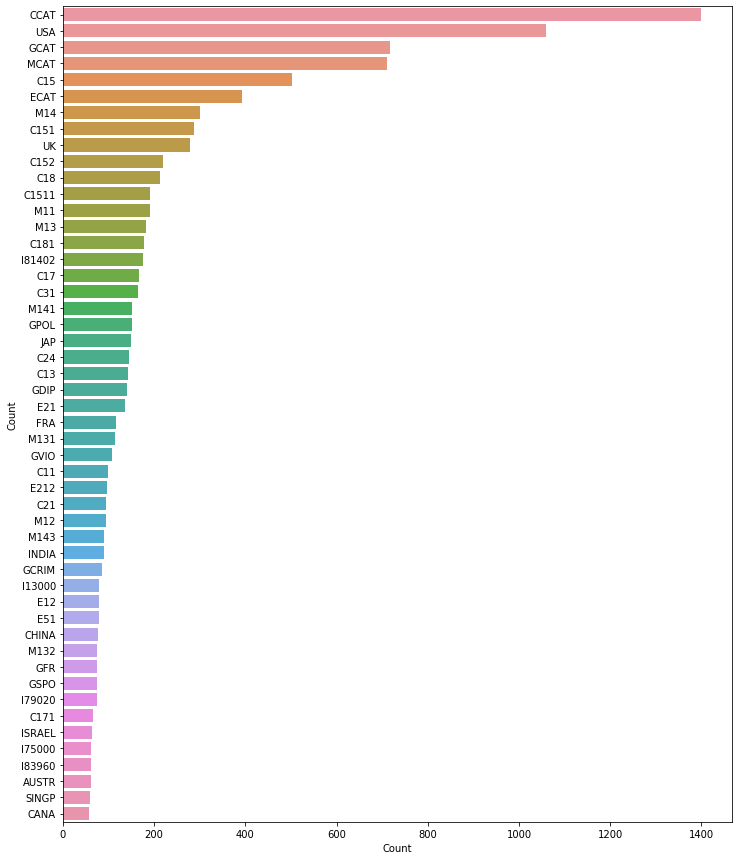

In [9]:
display_Codes(df)

In [10]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\n'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [11]:
lemmatizer = WordNetLemmatizer() 

def lemmatize(words):
    lemmatized_text = [lemmatizer.lemmatize(t, pos='n') for t in words] # lemmatized nouns
    return ''.join(lemmatized_text)

In [12]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)



In [13]:
def implement_clean_text(df):
    df['clean_text'] = df['text'].apply(lambda x: clean_text(x))
    df['clean_text'] = df['clean_text'].apply(lambda x: remove_stopwords(x))
    df['clean_text'] = df['clean_text'].apply(lambda x: lemmatize(x))
    return df

In [14]:
df = implement_clean_text(df)

In [15]:
#inspect column
df.loc[1]["clean_text"]


'decision eea joint committee october amending protocol eea agreement cooperation specific fields outside four freedoms decision eea joint committee january amending annex ii technical regulations standards testing certification eea agreement decision eea joint committee february amending annex vi social security eea agreement end document'

In [16]:
def create_encoder(data, input_column="clean_text", output_column="codes", X_encoder_filename = 'X_encoder.pickle', Y_encoder_filename='Y_encoder_pickle'):
    
    encoder = StaticTokenizerEncoder(data[input_column])
    
    multilabel_binarizer = MultiLabelBinarizer()
    multilabel_binarizer.fit(data[output_column])
    
    with open(X_encoder_filename, 'wb') as handle:
        pickle.dump(encoder, handle)
    with open(Y_encoder_filename, 'wb') as handle:
        pickle.dump(multilabel_binarizer, handle)
    
    return encoder, multilabel_binarizer

In [17]:
def tokenize_data(data,X_encoder, Y_encoder,input_column="clean_text", output_column="codes"):
    x_raw = [X_encoder.encode(x) for x in df[input_column]]
    max_len = max([len(x) for x in x_raw])
    x_raw = [pad_tensor(x, length=4395) for x in x_raw]
    
    y_raw = Y_encoder.transform(data[output_column])
    
    return x_raw, torch.from_numpy(y_raw)

In [18]:
def load_encoder(X_encoder_filename = 'X_encoder.pickle', Y_encoder_filename='Y_encoder_pickle'):
    with open (X_encoder_filename, 'rb') as handle:
        X_encoder = pickle.load(handle)
    
    with open(Y_encoder_filename, 'rb') as handle:
        Y_encoder = pickle.load(handle)
    
    return X_encoder, Y_encoder

In [19]:
use_preexisting_x_encoder = False
use_preexisting_y_encoder = False

In [20]:
if (use_preexisting_x_encoder and use_preexisting_y_encoder):
    x_encoder, y_encoder = load_encoder()
else:
    x_encoder, y_encoder = create_encoder(data=df)

In [21]:
x_input, y_input = tokenize_data(df, x_encoder, y_encoder)

In [22]:
x_input[0].type()

'torch.LongTensor'

In [23]:
y_input[0].type()

'torch.IntTensor'

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [24]:
torch.save(model.state_dict(), 'model.pkl')

NameError: name 'model' is not defined

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

## Predict for test set

You will be asked to return your predictions a separate test set.  These should be returned as a matrix with one row for each test article.  Each row contains a binary prediction for each label, 1 if it's present in the image, and 0 if not. The order of the labels is the order of the label (topic) codes.

An example row could like like this if your system predicts the presense of the second and fourth topic:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0 ...
    
If you have the matrix prepared in `y` you can use the following function to save it to a text file.

In [ ]:
np.savetxt('results.txt', y, fmt='%d')